# Sanity Checks

Any number of sanity checks on our data and models

## TODO
* https://arxiv.org/pdf/1103.2077.pdf doesn't work

# Preamble, Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [26]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits
import time

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Local libs
import sys
sys.path.append("..")

import plots, heatmaps, smhm_fit, cluster_sum, data, sc_plots
import lib.stellar_mass_function as smf

In [21]:
matplotlib.rcParams.update({'figure.dpi': 300})
def fig_font_size(size = 12):
    matplotlib.rcParams.update({'font.size': size})
fig_font_size()

# Important data cuts

In [4]:
centrals, satellites = data.load()

In [39]:
data_stellar_cut = data.sm_cuts_with_sats(centrals, satellites, smhm_fit.get_fit)
data_halo_cut = data.hm_cuts_with_sats(centrals, satellites, smhm_fit.get_fit_2)

# Broad sense of our data
Let's get a very broad sense of our data

In [6]:
print(centrals.dtype)
print(len(centrals))
print(len(satellites))

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<f8'), ('Halfmass_Scale', '<f8'), ('scale_of_last_MM', '<f8'), ('M200b', '<f8'), ('M200c', '<f8'), ('Acc_Rate_Inst', '<f8'), ('Acc_Rate_100Myr', '<f8'), ('Acc_Rate_1*Tdyn', '<f8'), ('Acc_Rate_2*Tdyn', '<f8'), ('Acc_Rate_Mpeak', '<f8'), ('Vmax@Mpeak', '<f8')]
385125
10809469


8 centrals without ICL of our 385125 samples


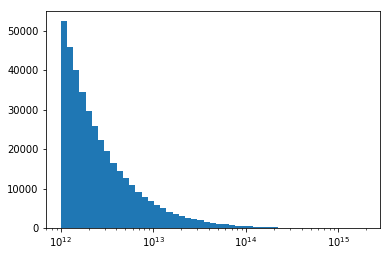

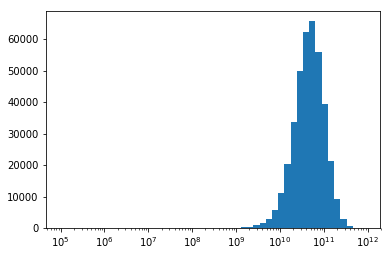

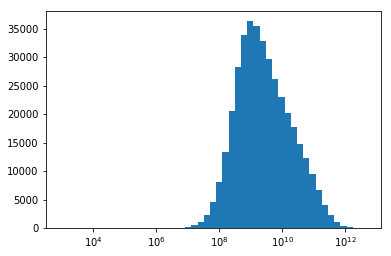

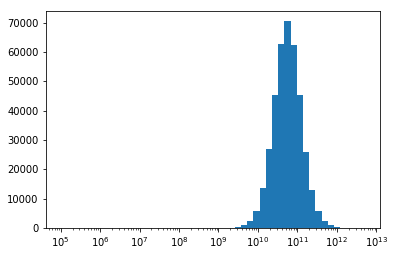

In [7]:
fig, ax = plt.subplots()
_ = ax.hist(centrals["mp"], bins = np.geomspace(np.amin(centrals["mp"]), np.amax(centrals["mp"]), 50))
_ = ax.set(xscale="log")

fig, ax = plt.subplots()
_ = ax.hist(centrals["sm"], bins = np.geomspace(np.amin(centrals["sm"]), np.amax(centrals["sm"]), 50))
_ = ax.set(xscale="log")

fcentrals = centrals[np.nonzero(centrals["icl"])[0]]
fig, ax = plt.subplots()
_ = ax.hist(fcentrals["icl"], bins = np.geomspace(np.amin(fcentrals["icl"]), np.amax(fcentrals["icl"]), 50))
_ = ax.set(xscale="log")
print(
    "{} centrals without ICL of our {} samples".format(len(centrals) - len(np.nonzero(centrals["icl"])[0]), len(centrals))
)

fig, ax = plt.subplots()
_ = ax.hist(
    centrals["icl"] + centrals["sm"],
    bins = np.geomspace(
        np.amin(centrals["icl"]) + np.amin(centrals["sm"]),
        np.amax(centrals["icl"]) + np.amax(centrals["sm"]),
        50))
_ = ax.set(xscale="log")

# WTF is up with insitu at halo masses between 14.25 and 15

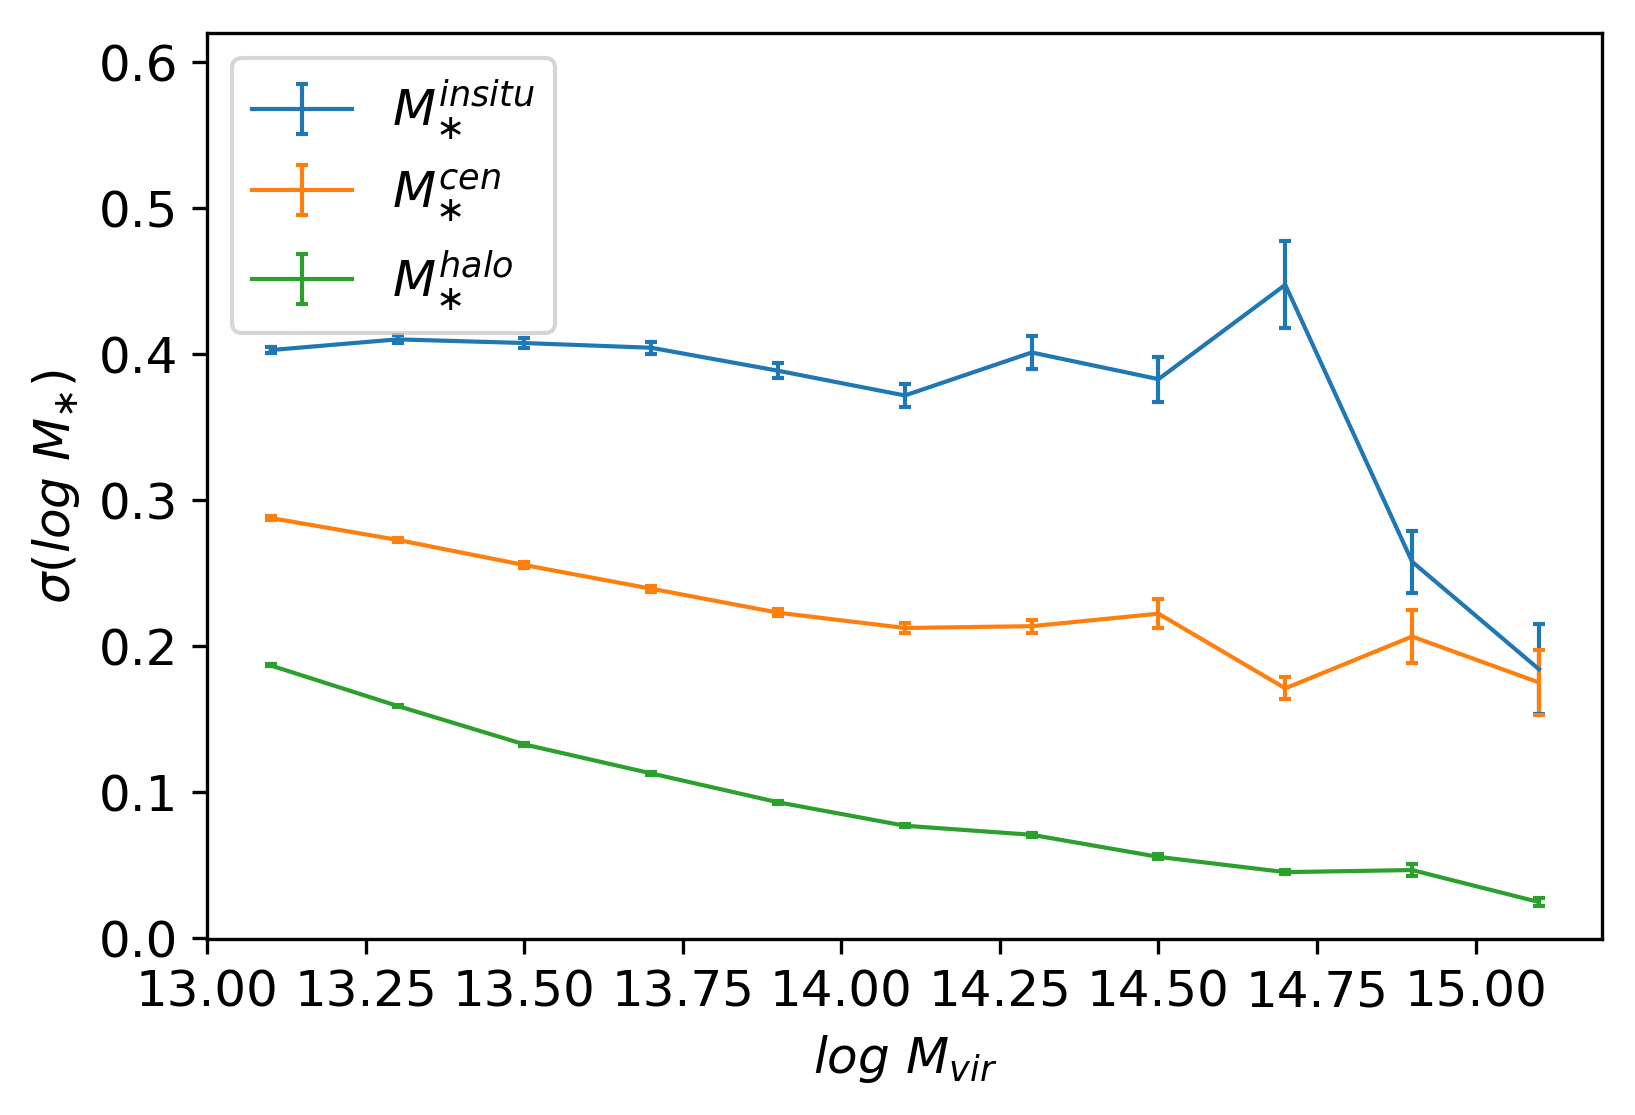

In [45]:
plots.hm_vs_sm_scatter_variant(data_halo_cut)

36491
36490


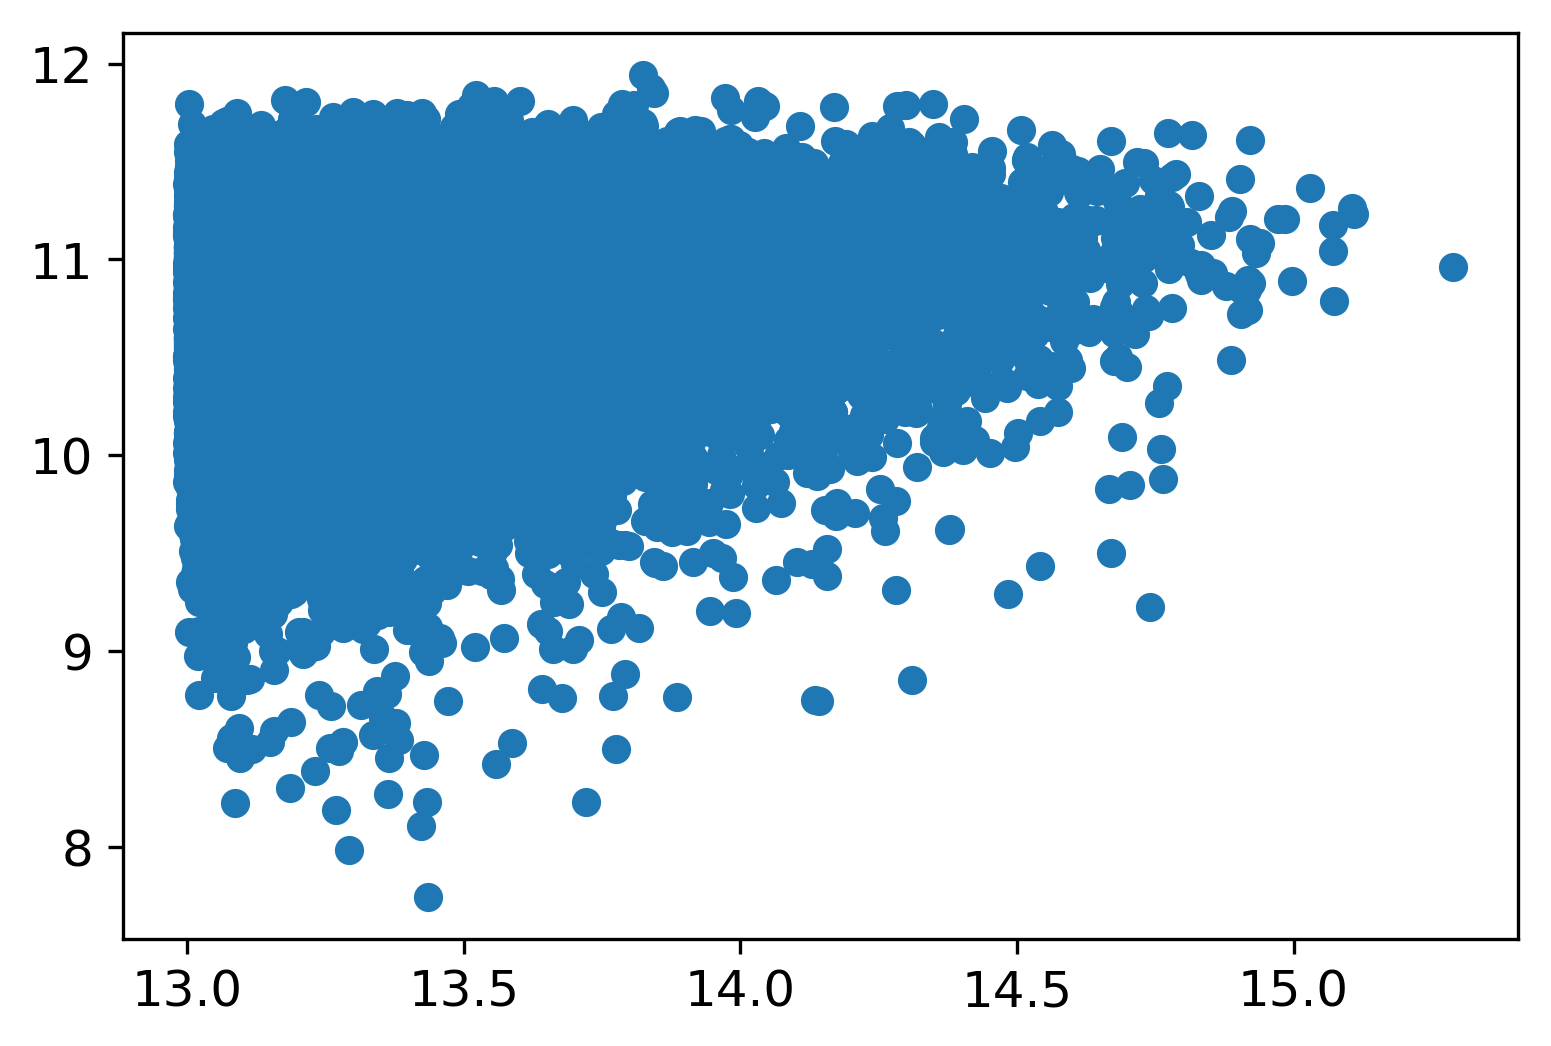

In [32]:
sc_plots.whats_up_with_insitu(data_halo_cut)

# Scatter in thin bins

To make sure everything else works when we start using fits, lets just see roughly what our scatter should be in various places.

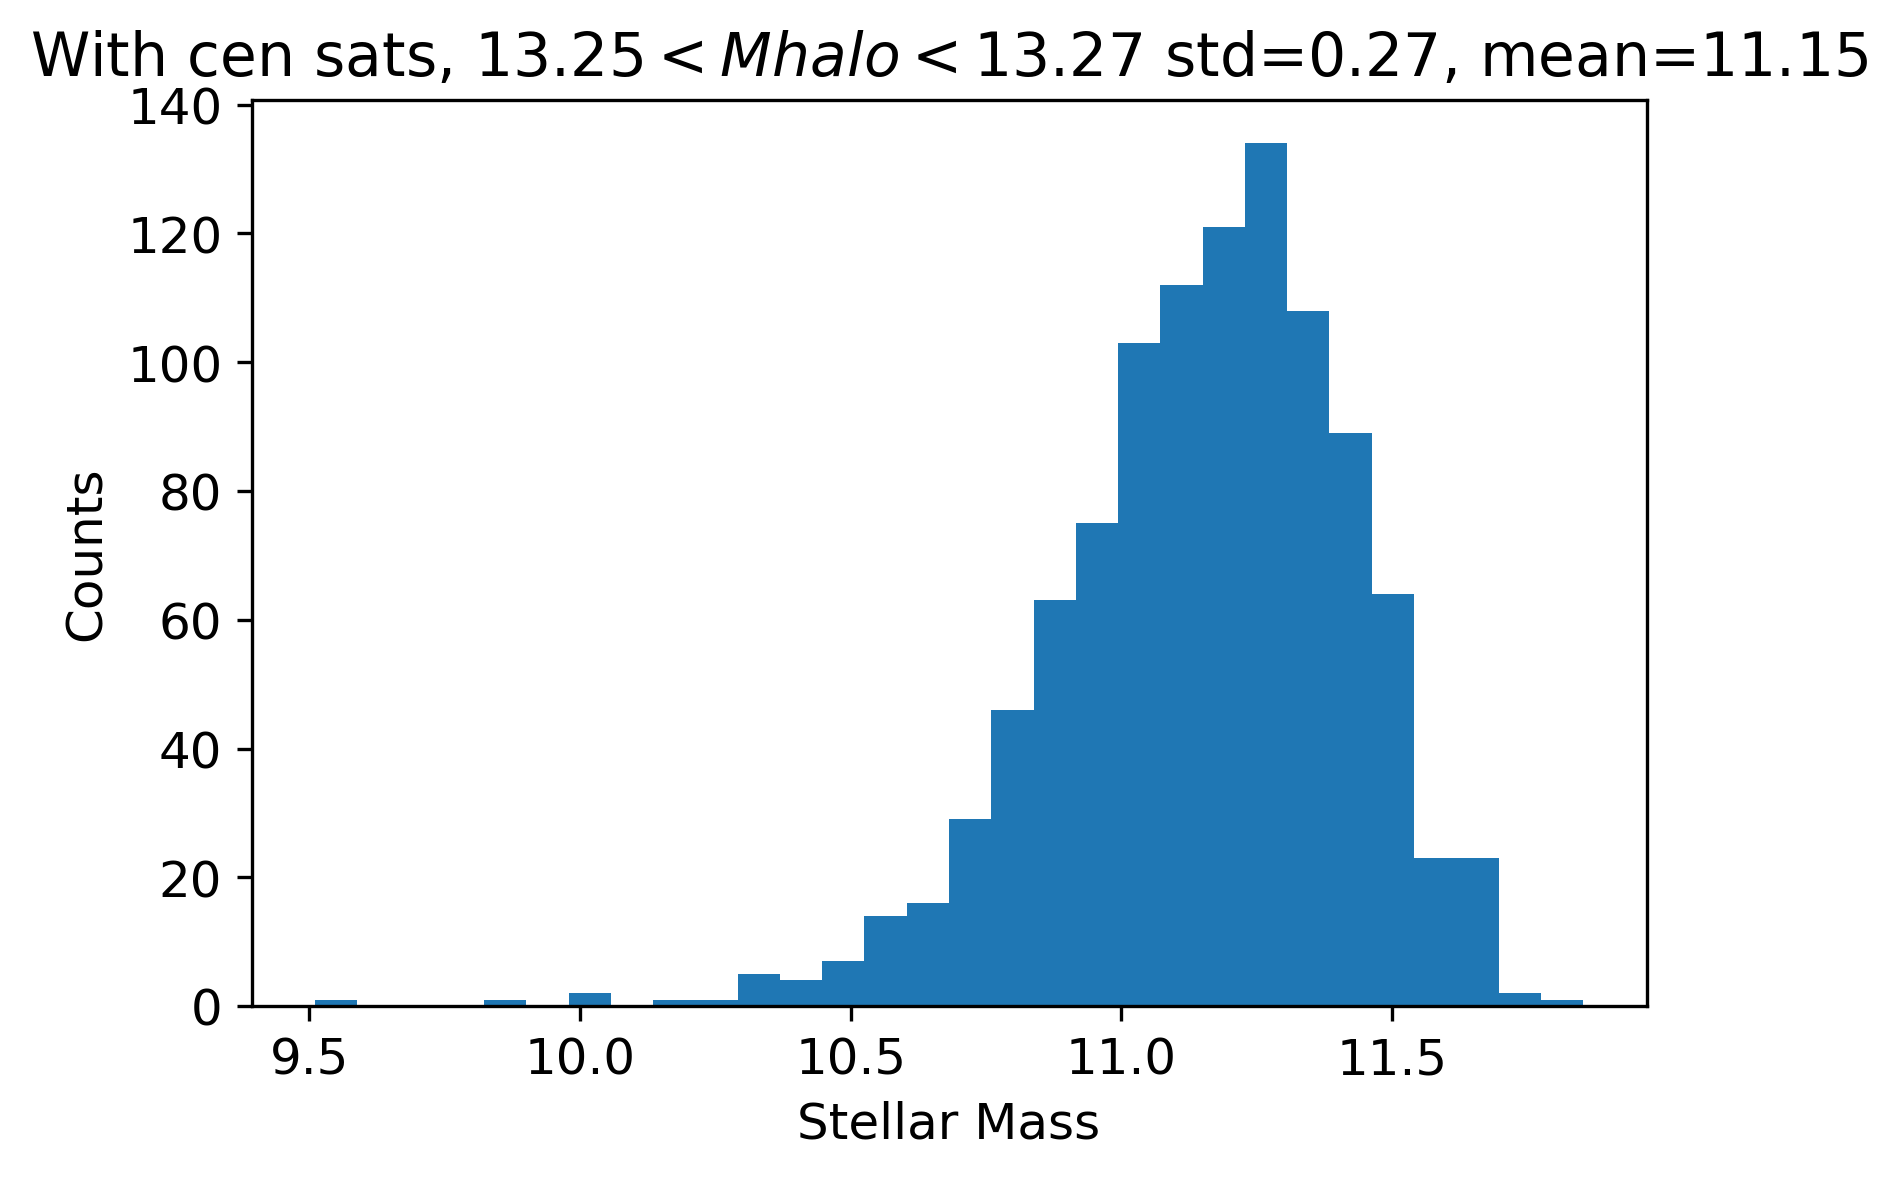

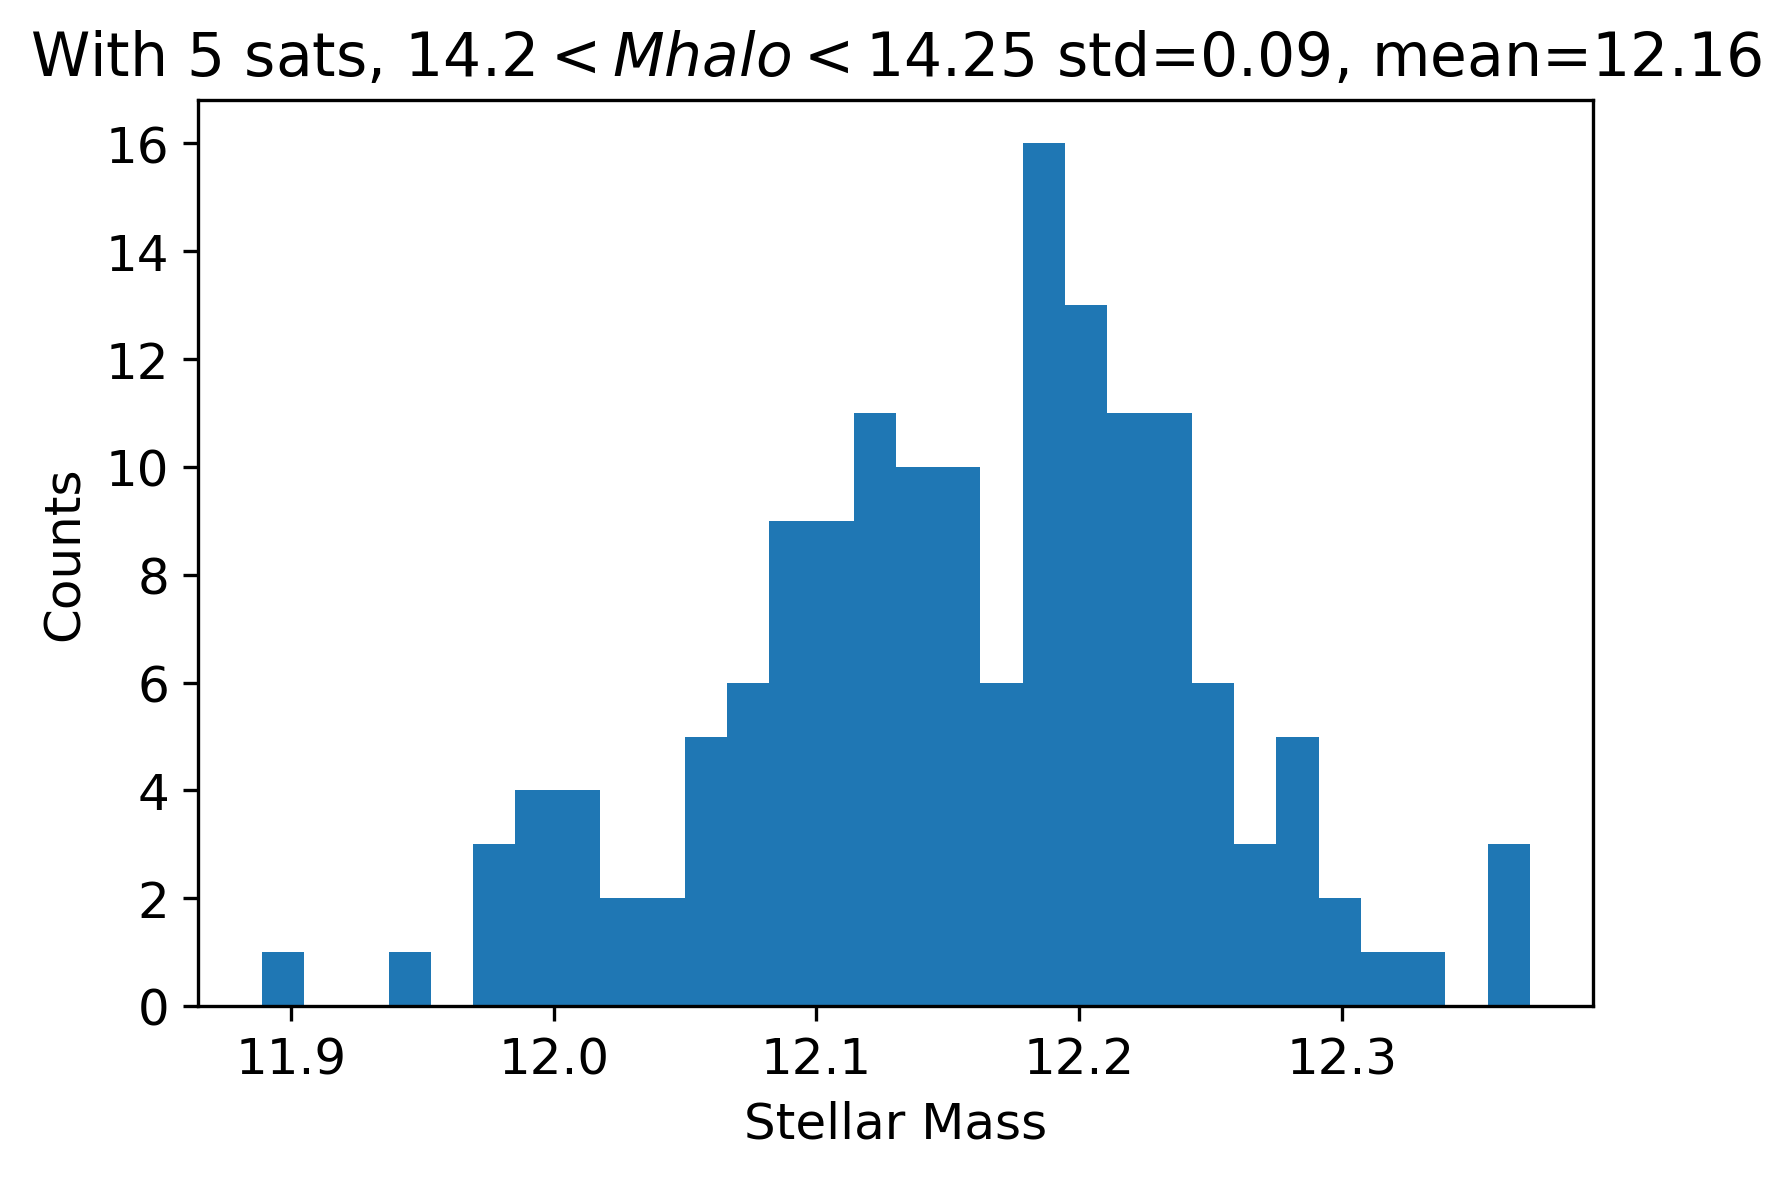

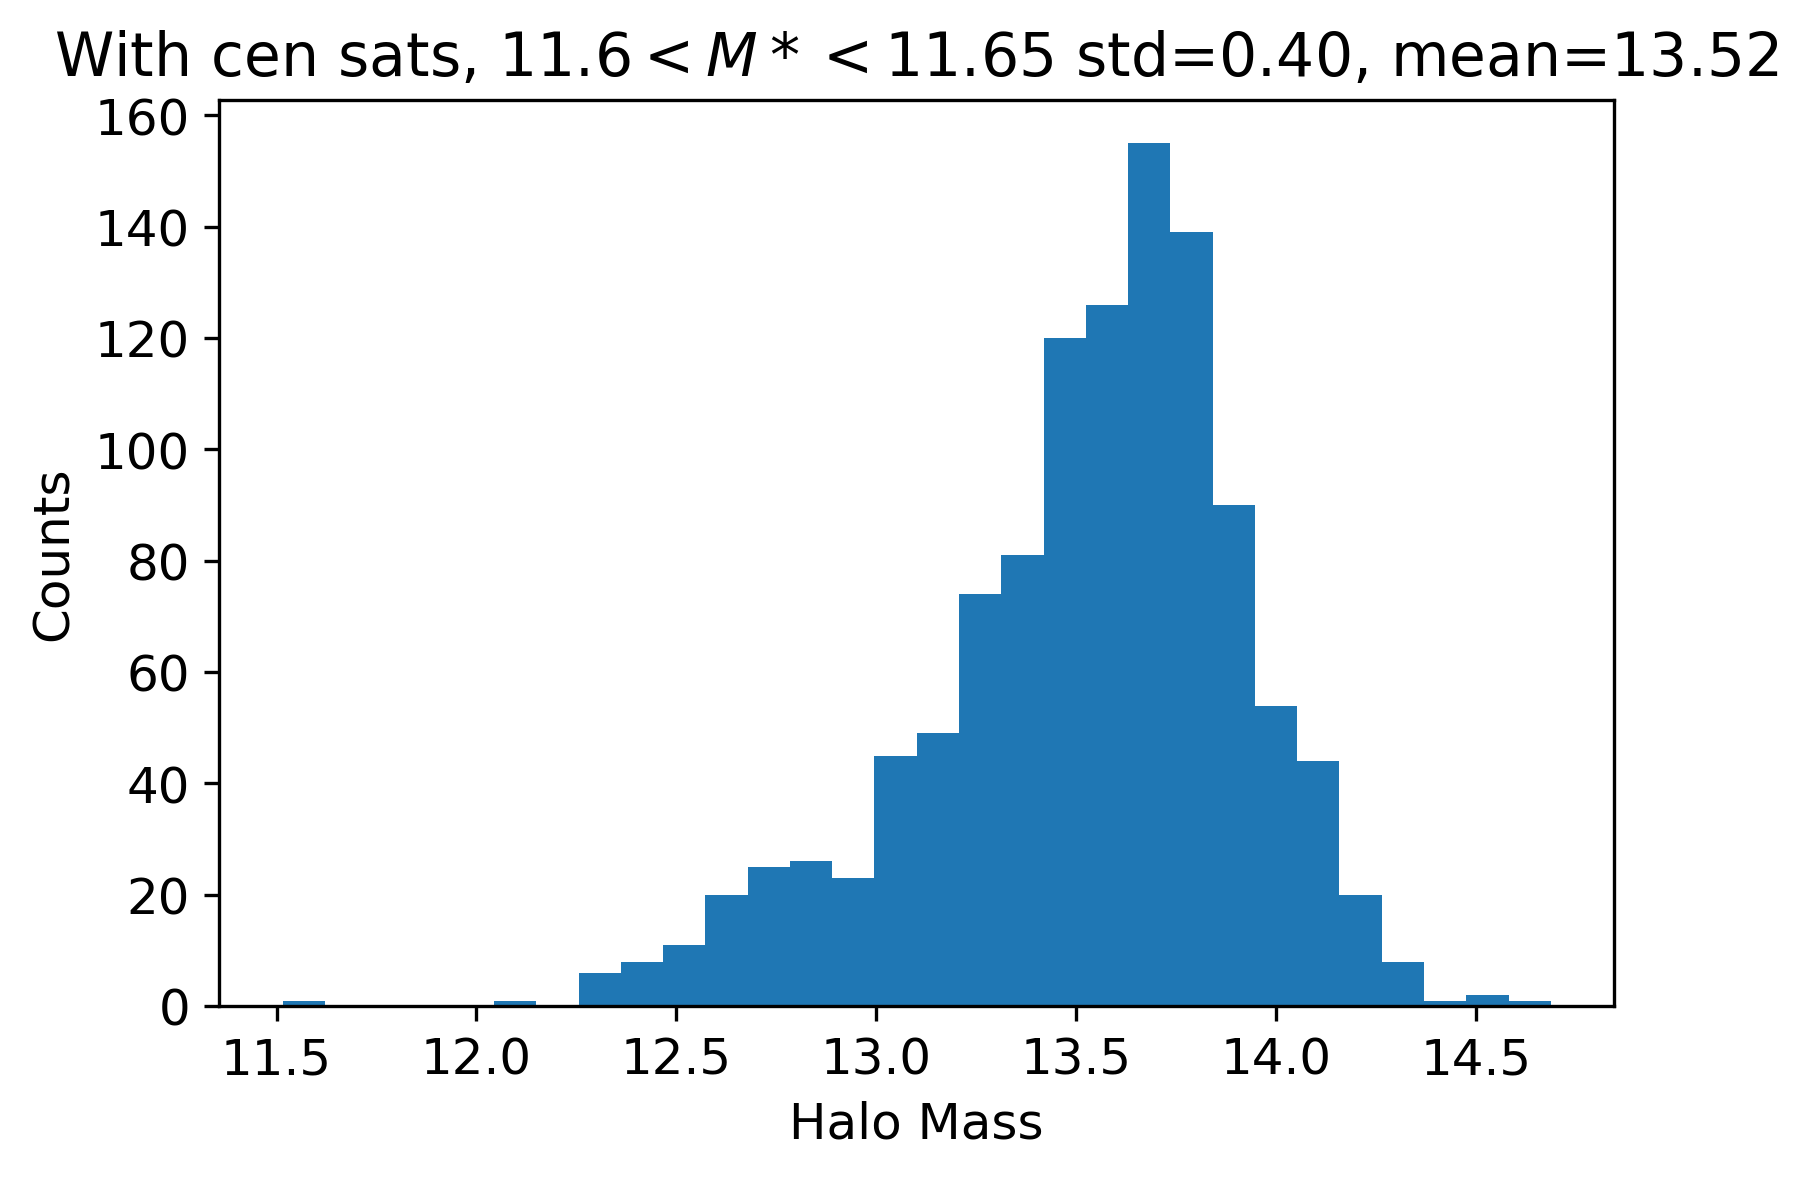

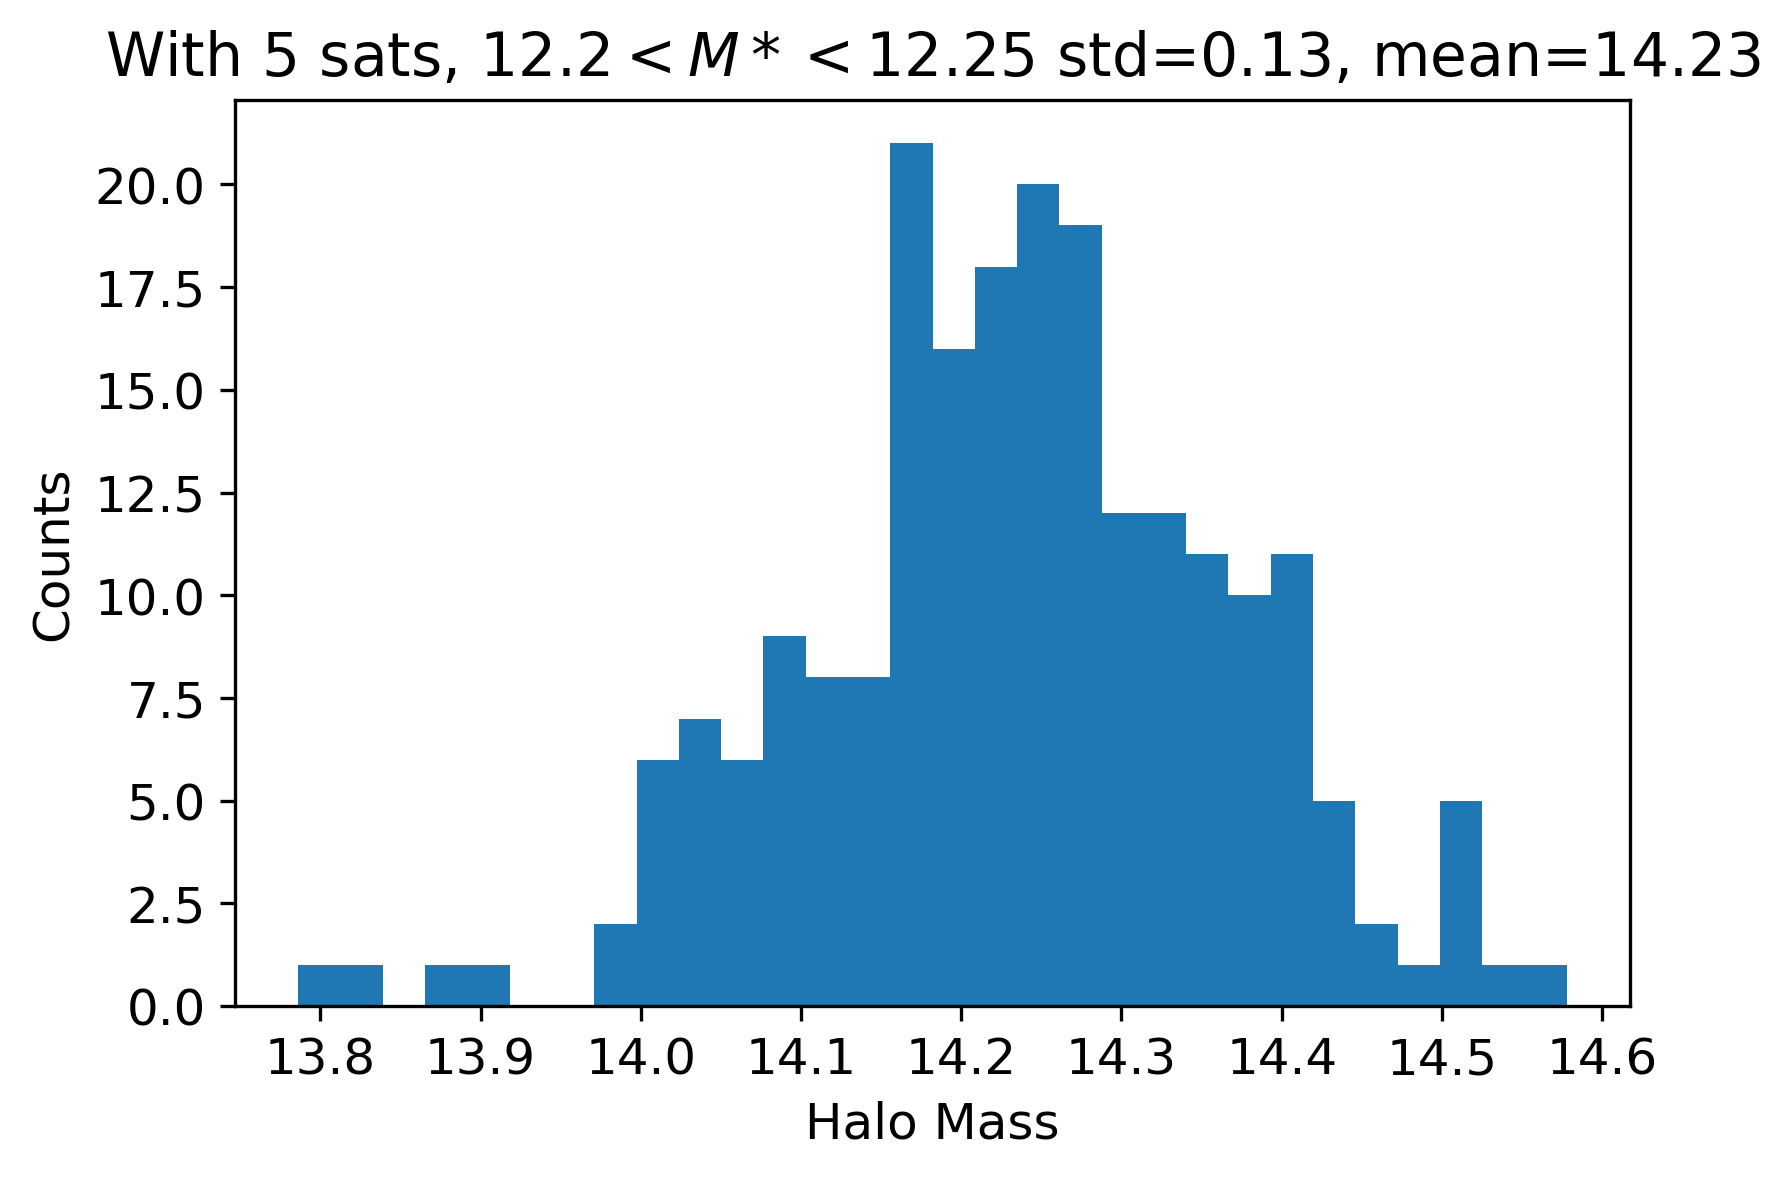

In [22]:
# In a thin halo mass bound
for (n_sats, lower_bound, upper_bound) in [("cen", 13.25, 13.27), (5, 14.2, 14.25)]:
    thin_halo_bin = data_halo_cut[n_sats]["data"][(data_halo_cut[n_sats]["data"]["m"] > 10**lower_bound) & (data_halo_cut[n_sats]["data"]["m"] < 10**upper_bound)]
    sm = np.log10(thin_halo_bin["sm"] + thin_halo_bin["icl"])

    fig, ax = plt.subplots()
    _ = ax.hist(sm, bins=30)
    _ = ax.set(
        title="With {n_sats} sats, ${lower_bound} < Mhalo < {upper_bound}$ std={std:.2f}, mean={mean:.2f}".format(
            **{"n_sats": n_sats, "lower_bound": lower_bound, "upper_bound": upper_bound, "std": np.std(sm), "mean": np.mean(sm)}),
        ylabel="Counts",
        xlabel="Stellar Mass",
    )

# In a thin stellar mass bound
for (n_sats, lower_bound, upper_bound) in [("cen", 11.6, 11.65), (5, 12.2, 12.25)]:
    sm = data_stellar_cut[n_sats]["data"]["sm"] + data_stellar_cut[n_sats]["data"]["icl"]
    thin_sm_bin = data_stellar_cut[n_sats]["data"][(sm > 10**lower_bound) & (sm < 10**upper_bound)]
    hm = np.log10(thin_sm_bin["m"])

    fig, ax = plt.subplots()
    _ = ax.hist(hm, bins=30)
    _ = ax.set(
        title="With {n_sats} sats, ${lower_bound} < M* < {upper_bound}$ std={std:.2f}, mean={mean:.2f}".format(
            **{"n_sats": n_sats, "lower_bound": lower_bound, "upper_bound": upper_bound, "std": np.std(hm), "mean": np.mean(hm)}),
        ylabel="Counts",
        xlabel="Halo Mass",
    )

# Sanity check the fit

When we create our data with the sats we get a fit.
```
data_stellar_cut[0] = {
    data: [ numpy array with 1 cluster per row ], 
    fit: the best fit params that when given to f_shmr_inverse map SM to HM,
}
```

### Let's just make sure that these fits actually fit the data

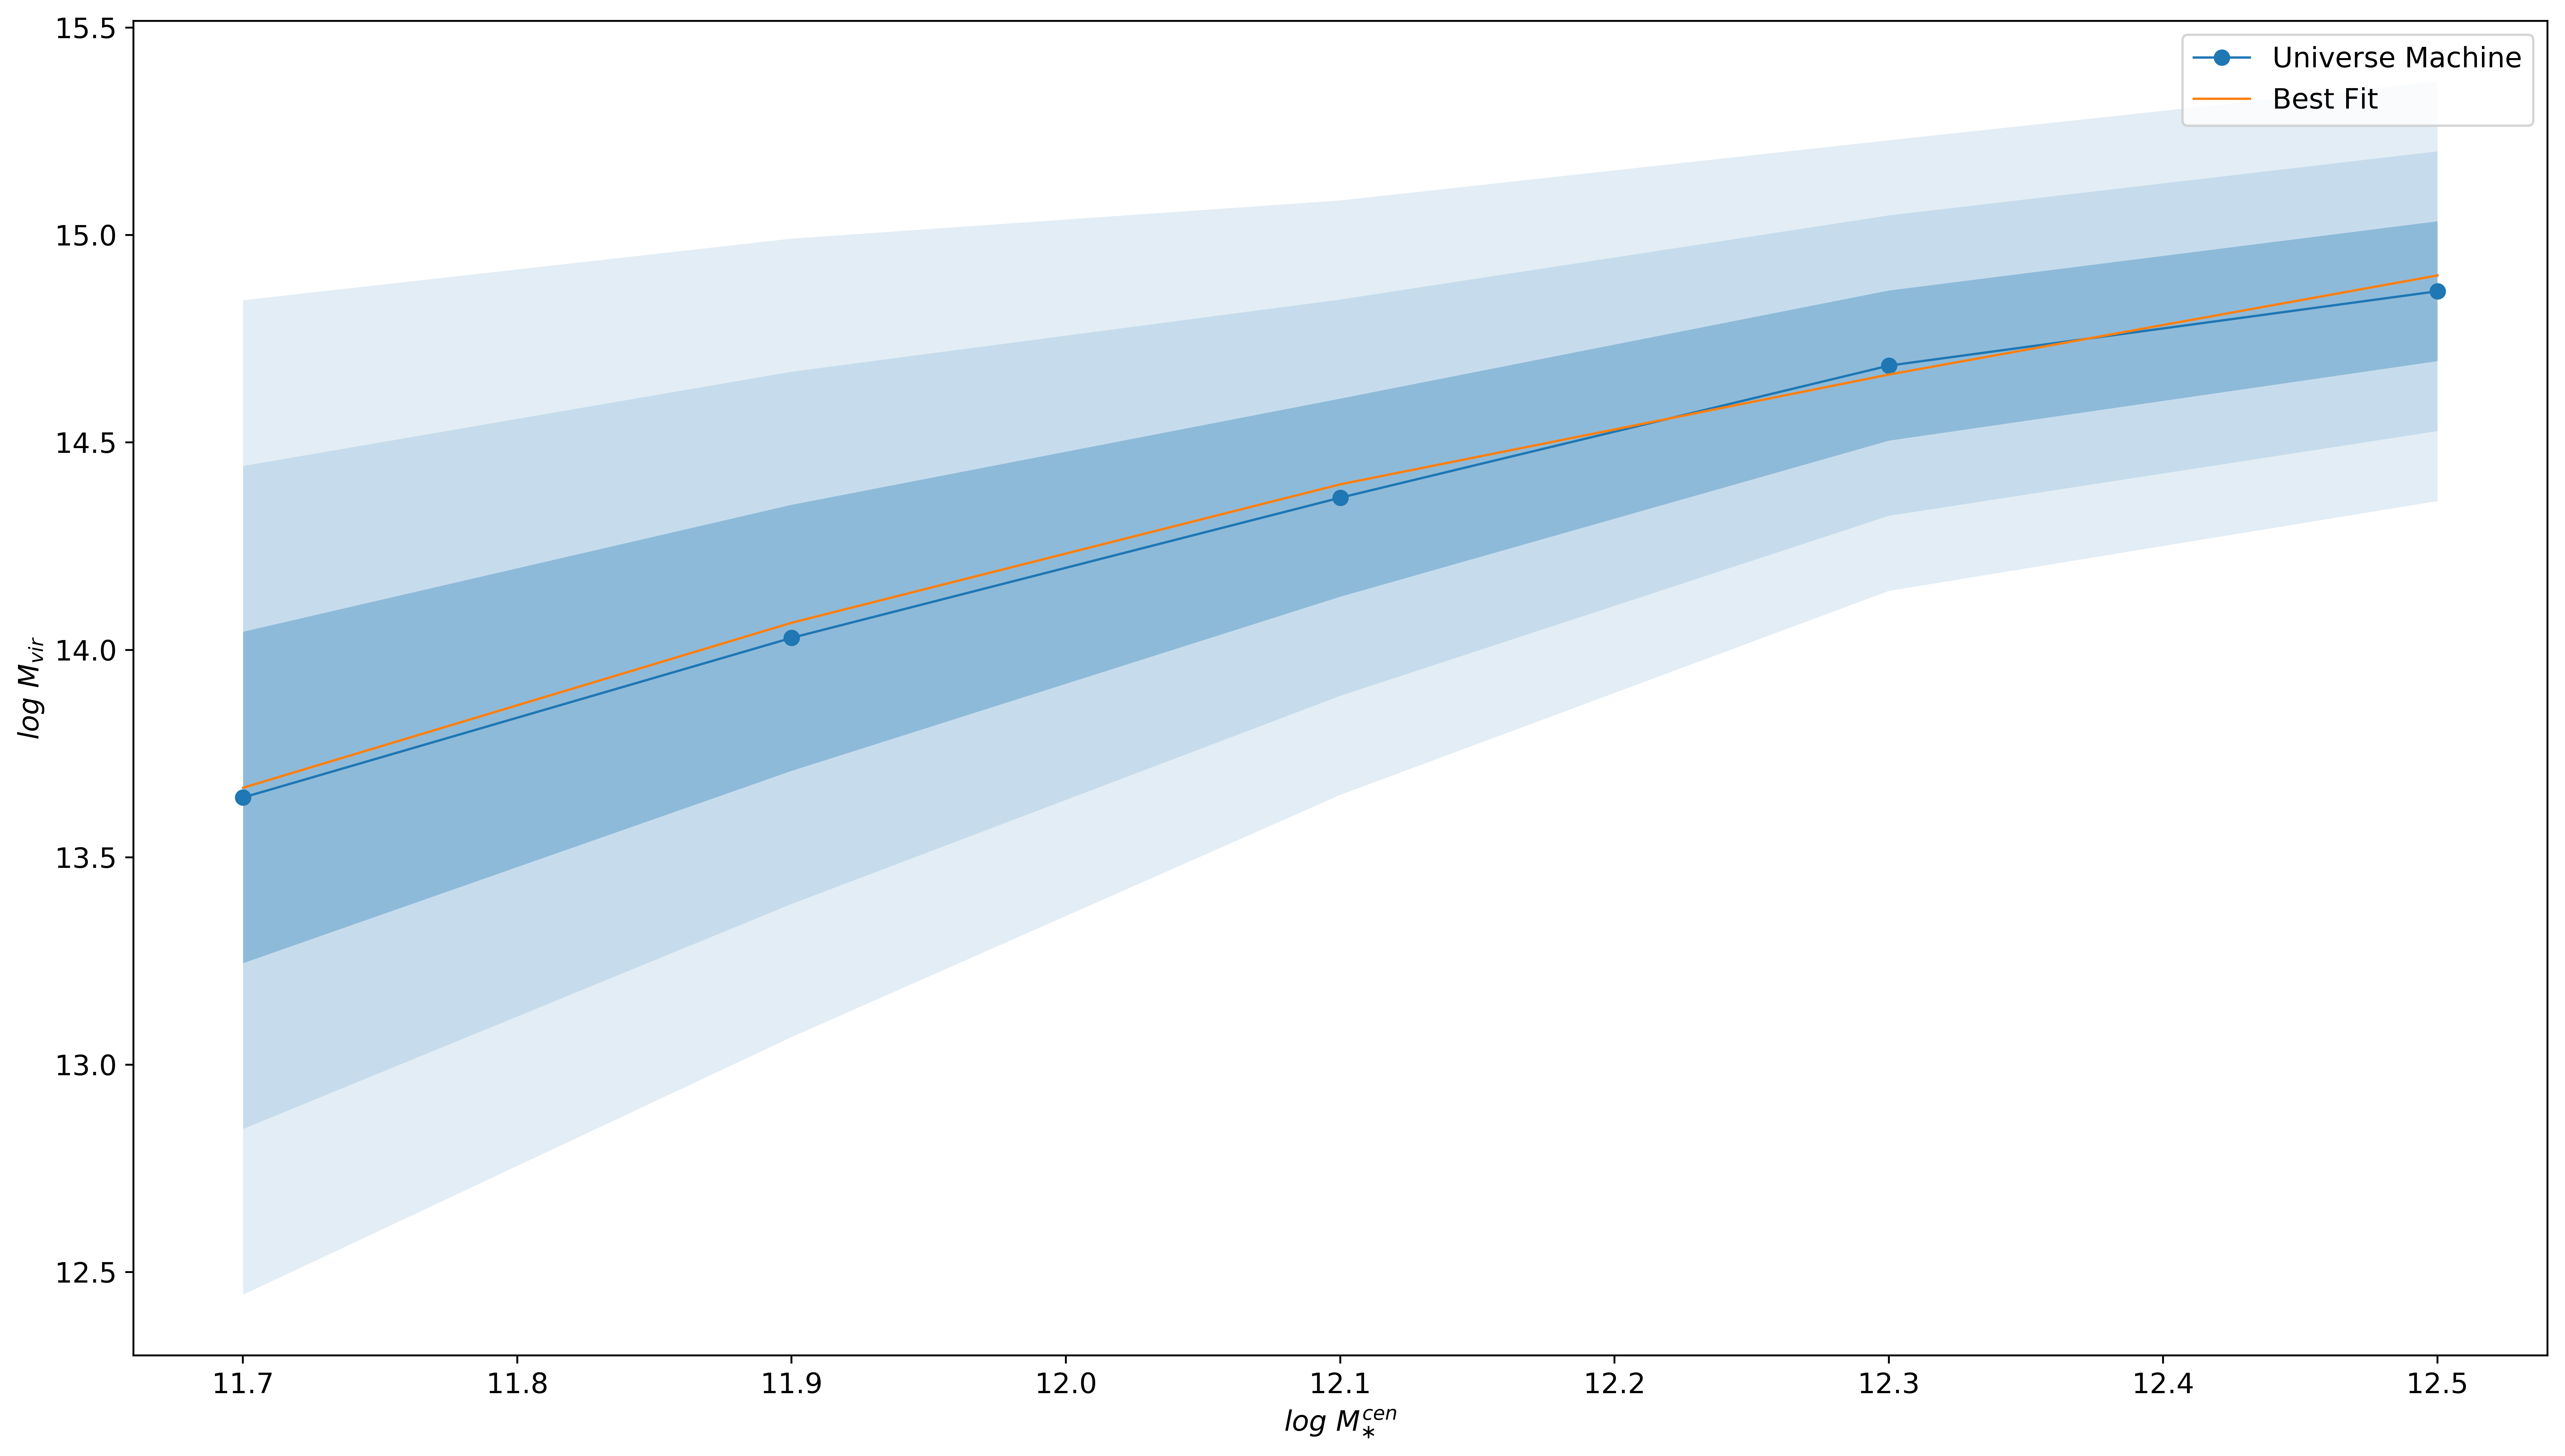

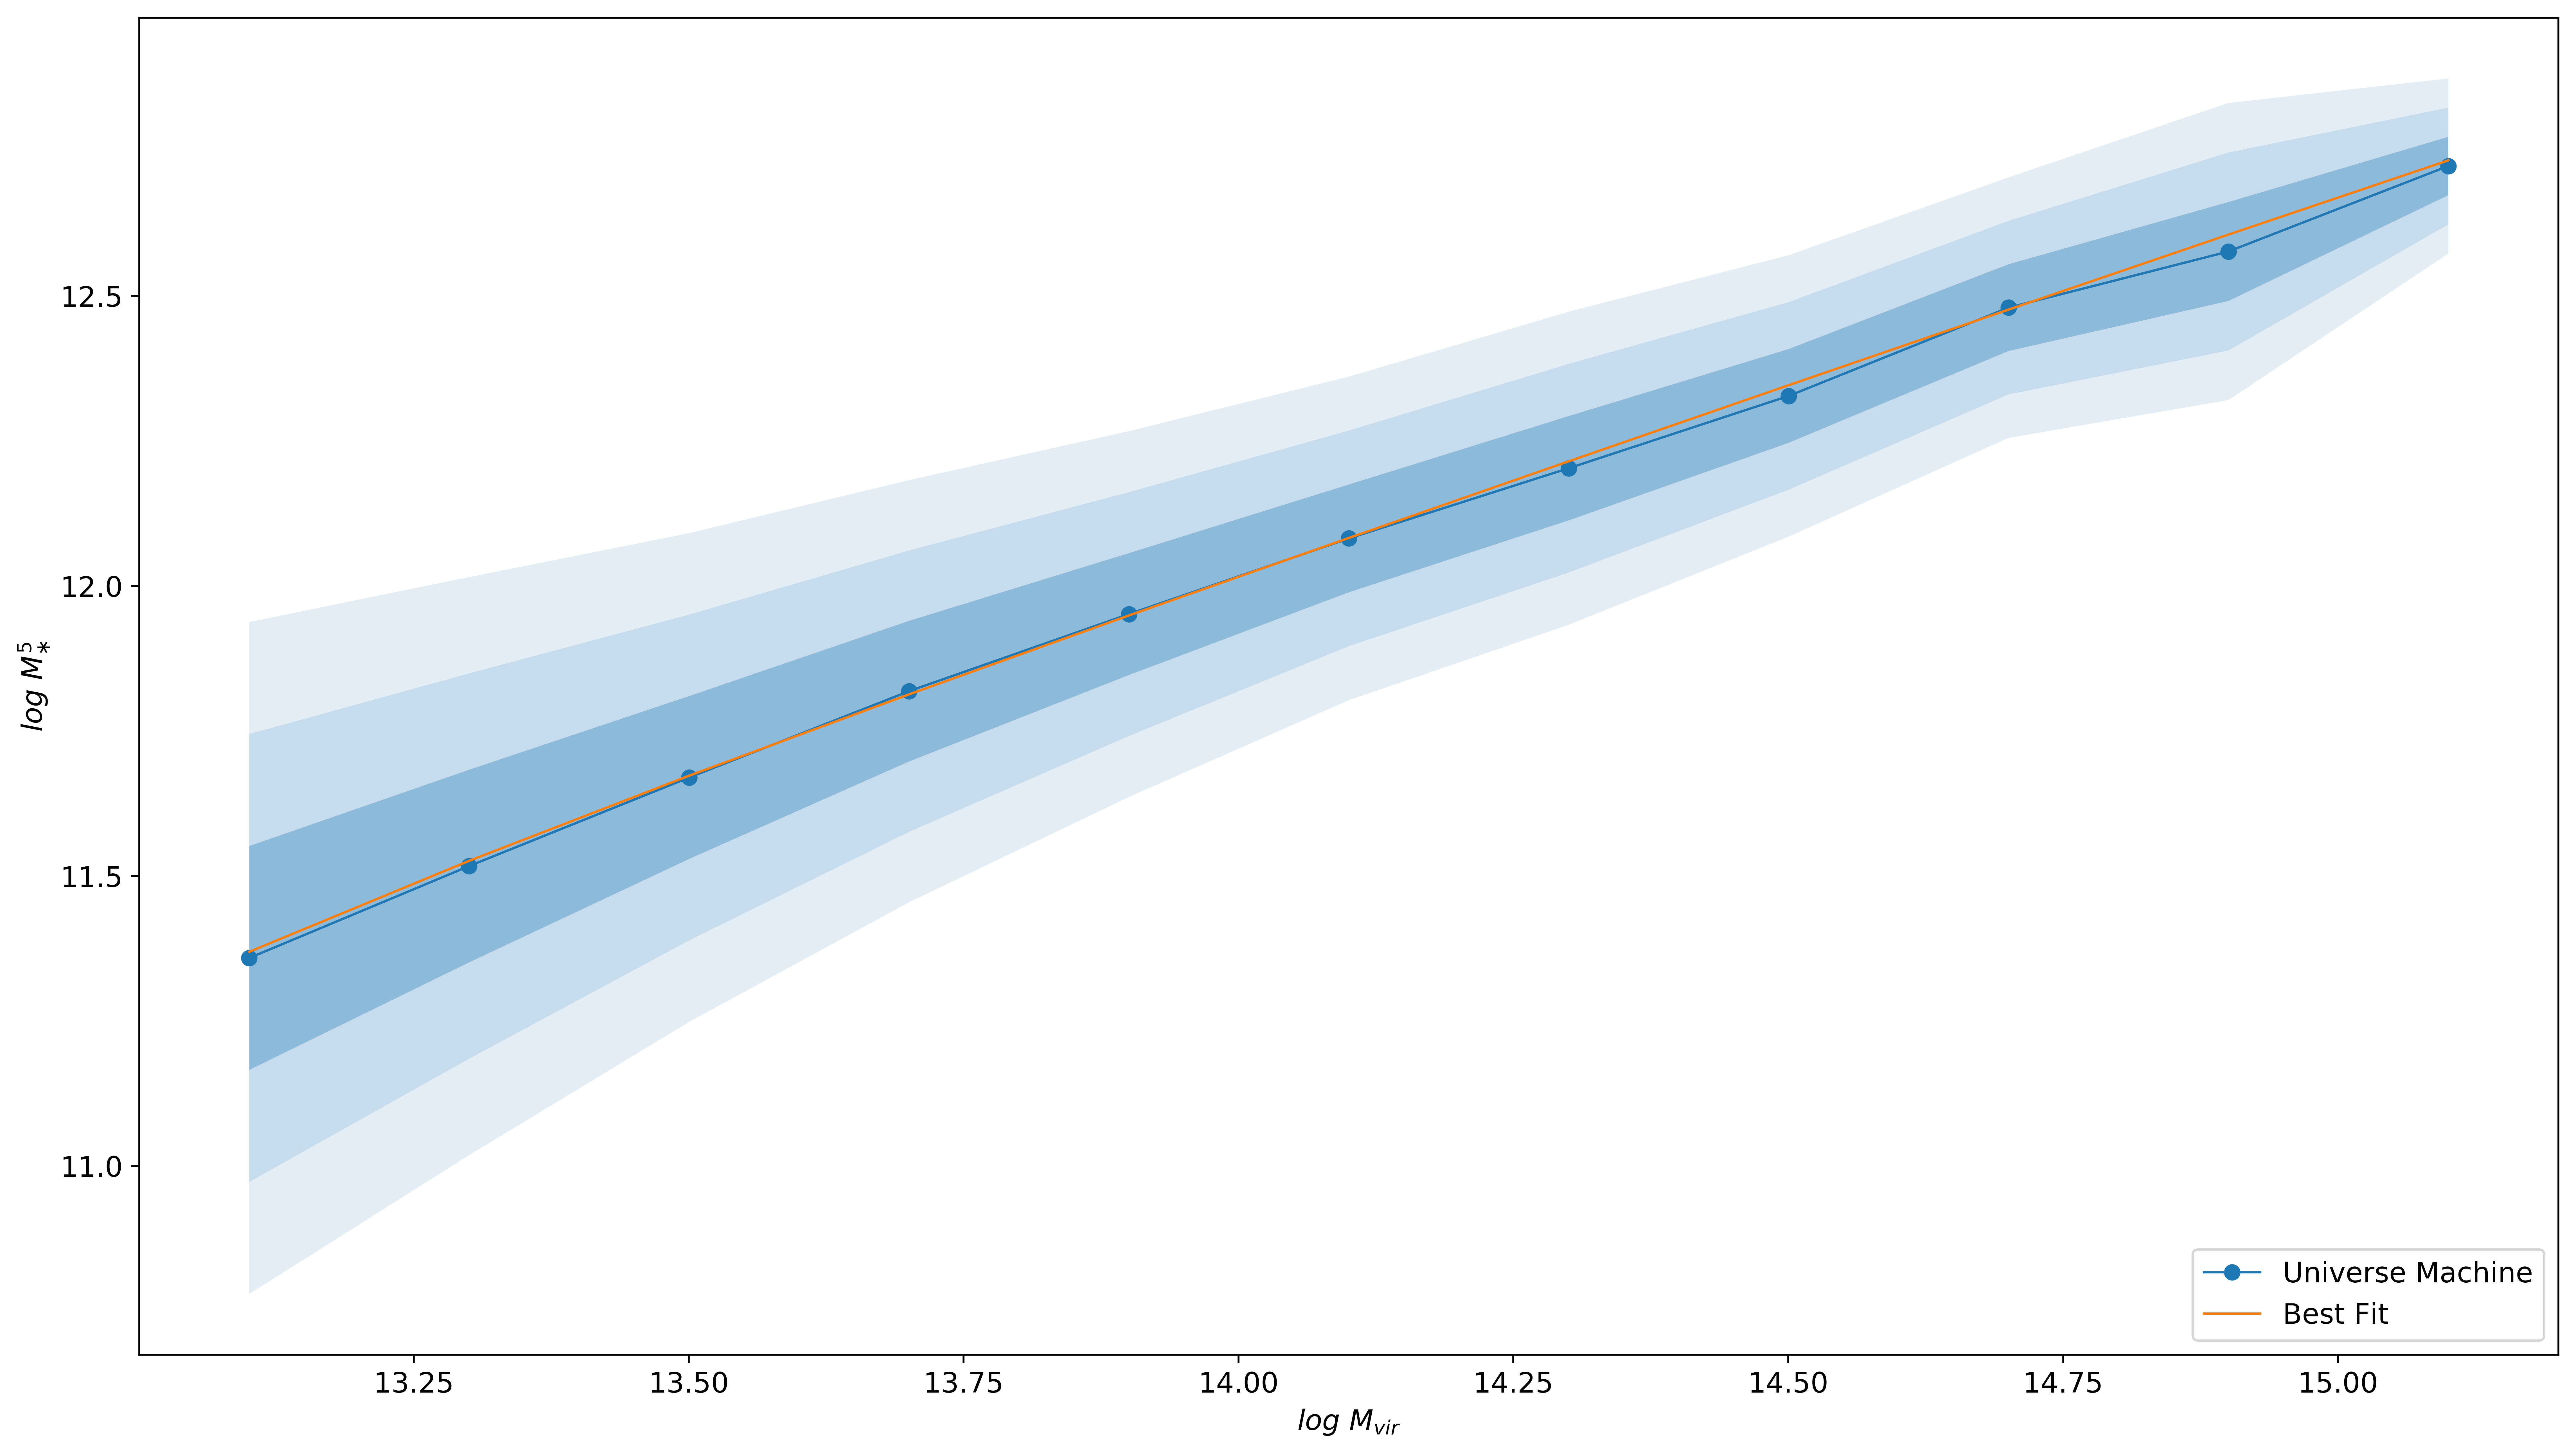

In [6]:
ax = plots.dm_vs_sm(data_stellar_cut["cen"]["data"], "cen", fit=data_stellar_cut["cen"]["fit"])
ax = plots.sm_vs_dm(data_halo_cut[5]["data"], 5, fit=data_halo_cut[5]["fit"])

###  Now show that our fits invert themselves

[  4.63473374e+13   5.00534816e+11   2.35358911e-01   2.42163939e-01
   2.51385947e+00]
A log stellar mass of 12 results in a log halo mass of 14.242636407166584
The derivative d_log_halo_mass/d_log_stellar_mass at this point is 1.6657463176368836
Derivative sanity check 1.6668703252165074
Going the other way, a log halo mass of 14 results in a log stellar mass of [ 11.86618554]
This is fast. We can get 15000 of SM from HM in 0.38s
Max error when going from SM - HM - SM: 2.3714363805993344e-12


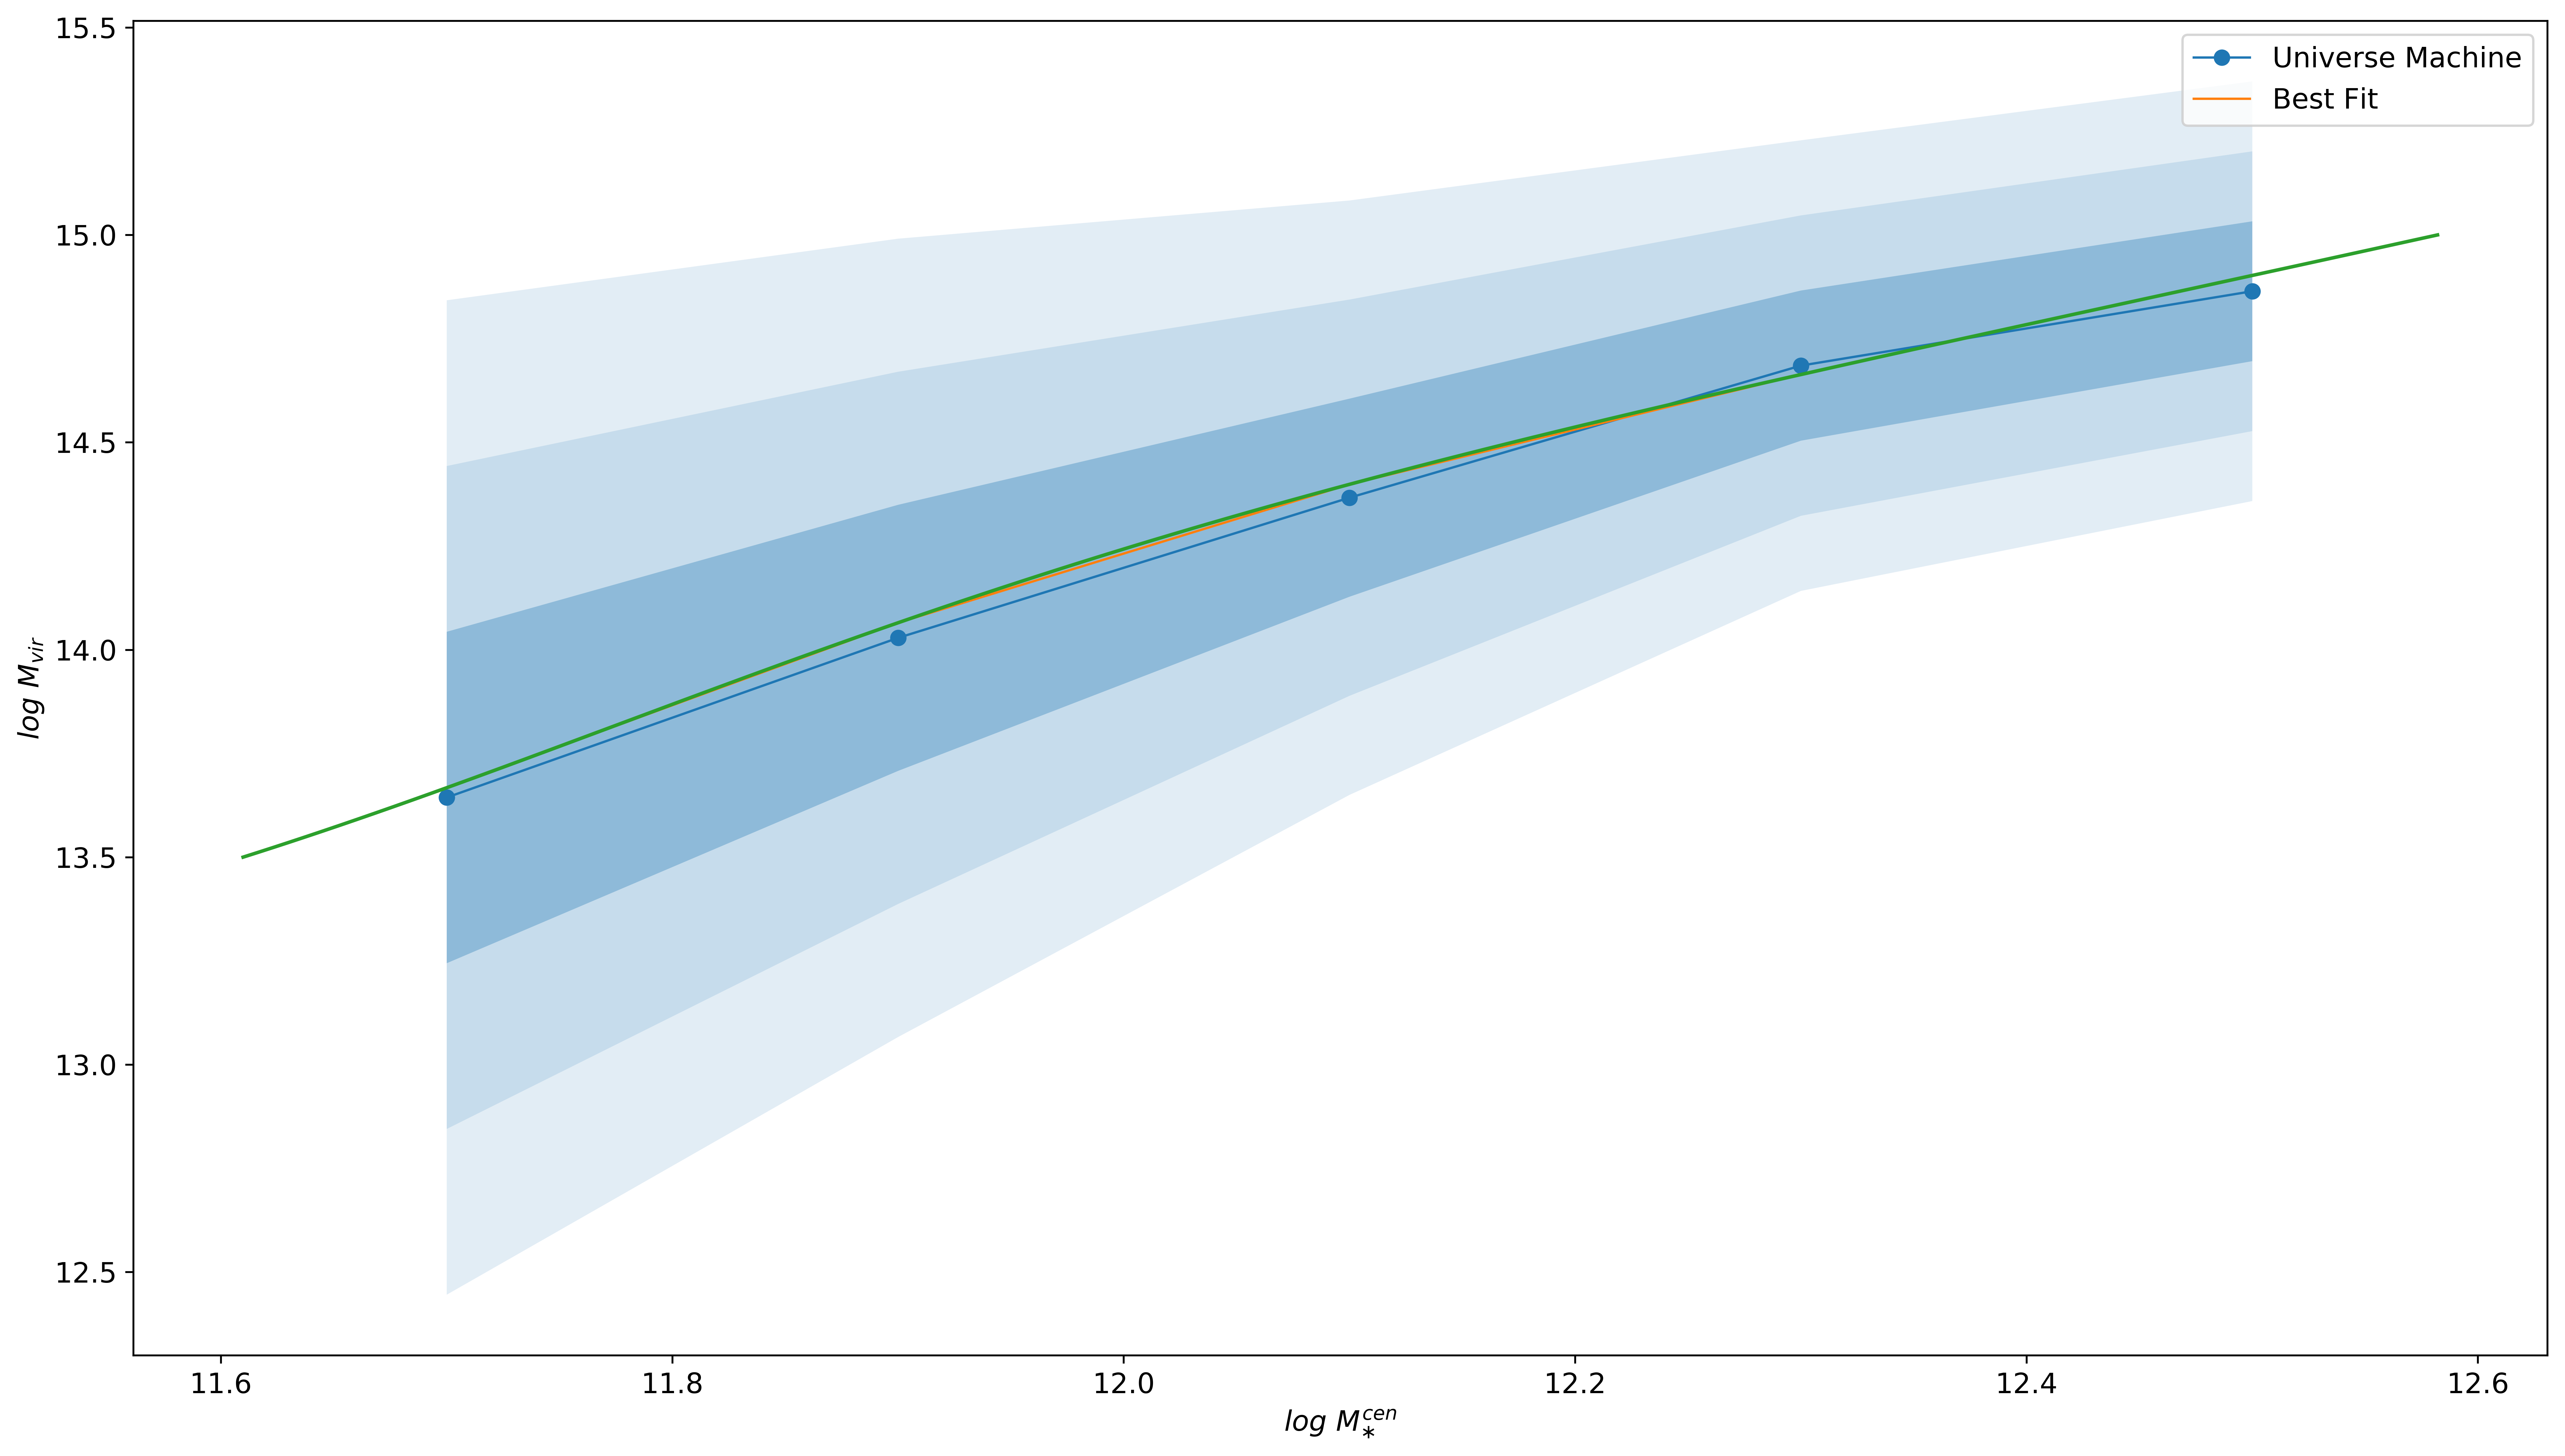

In [9]:
# Show that our functional form works and inverts itself
fit = smhm_fit.get_fit(data_stellar_cut["cen"]["data"])
ax = plots.dm_vs_sm(data_stellar_cut["cen"]["data"], "cen", fit=data_stellar_cut["cen"]["fit"])
print(fit)

log_sm = 12
print("A log stellar mass of {0} results in a log halo mass of {1}".format(
    log_sm, smhm_fit.f_shmr_inverse(log_sm, *fit)))

print("The derivative d_log_halo_mass/d_log_stellar_mass at this point is {}".format(smhm_fit.f_shmr_inverse_der(log_sm, *fit[1:])))
print("Derivative sanity check {}".format(
    (smhm_fit.f_shmr_inverse(log_sm, *fit)-smhm_fit.f_shmr_inverse(log_sm-0.001, *fit))/0.001))

log_hm = 14
print("Going the other way, a log halo mass of {0} results in a log stellar mass of {1}".format(
    log_hm, smhm_fit.f_shmr(log_hm, *fit)))


# Test speed
log_hms = np.arange(13.5, 15, 0.0001)
before = time.time()
log_sms = smhm_fit.f_shmr(log_hms, *fit)
after = time.time()
print("This is fast. We can get {0} of SM from HM in {1:.2f}s".format(
    len(log_hms), after - before))

ax.plot(log_sms, log_hms)

# Test accuracy
stellar_masses = np.arange(11, 12.5, 0.01)
halo_masses = smhm_fit.f_shmr_inverse(stellar_masses, *fit)
out_stellar_masses = smhm_fit.f_shmr(halo_masses, *fit)
print("Max error when going from SM - HM - SM: {}".format(max(out_stellar_masses - stellar_masses)))

### Compare SM scatter to HM scatter

https://arxiv.org/pdf/1103.2077.pdf presents a proposed relation between sm scatter at fixed hm and hm scatter at fixed sm. (Equation 4)


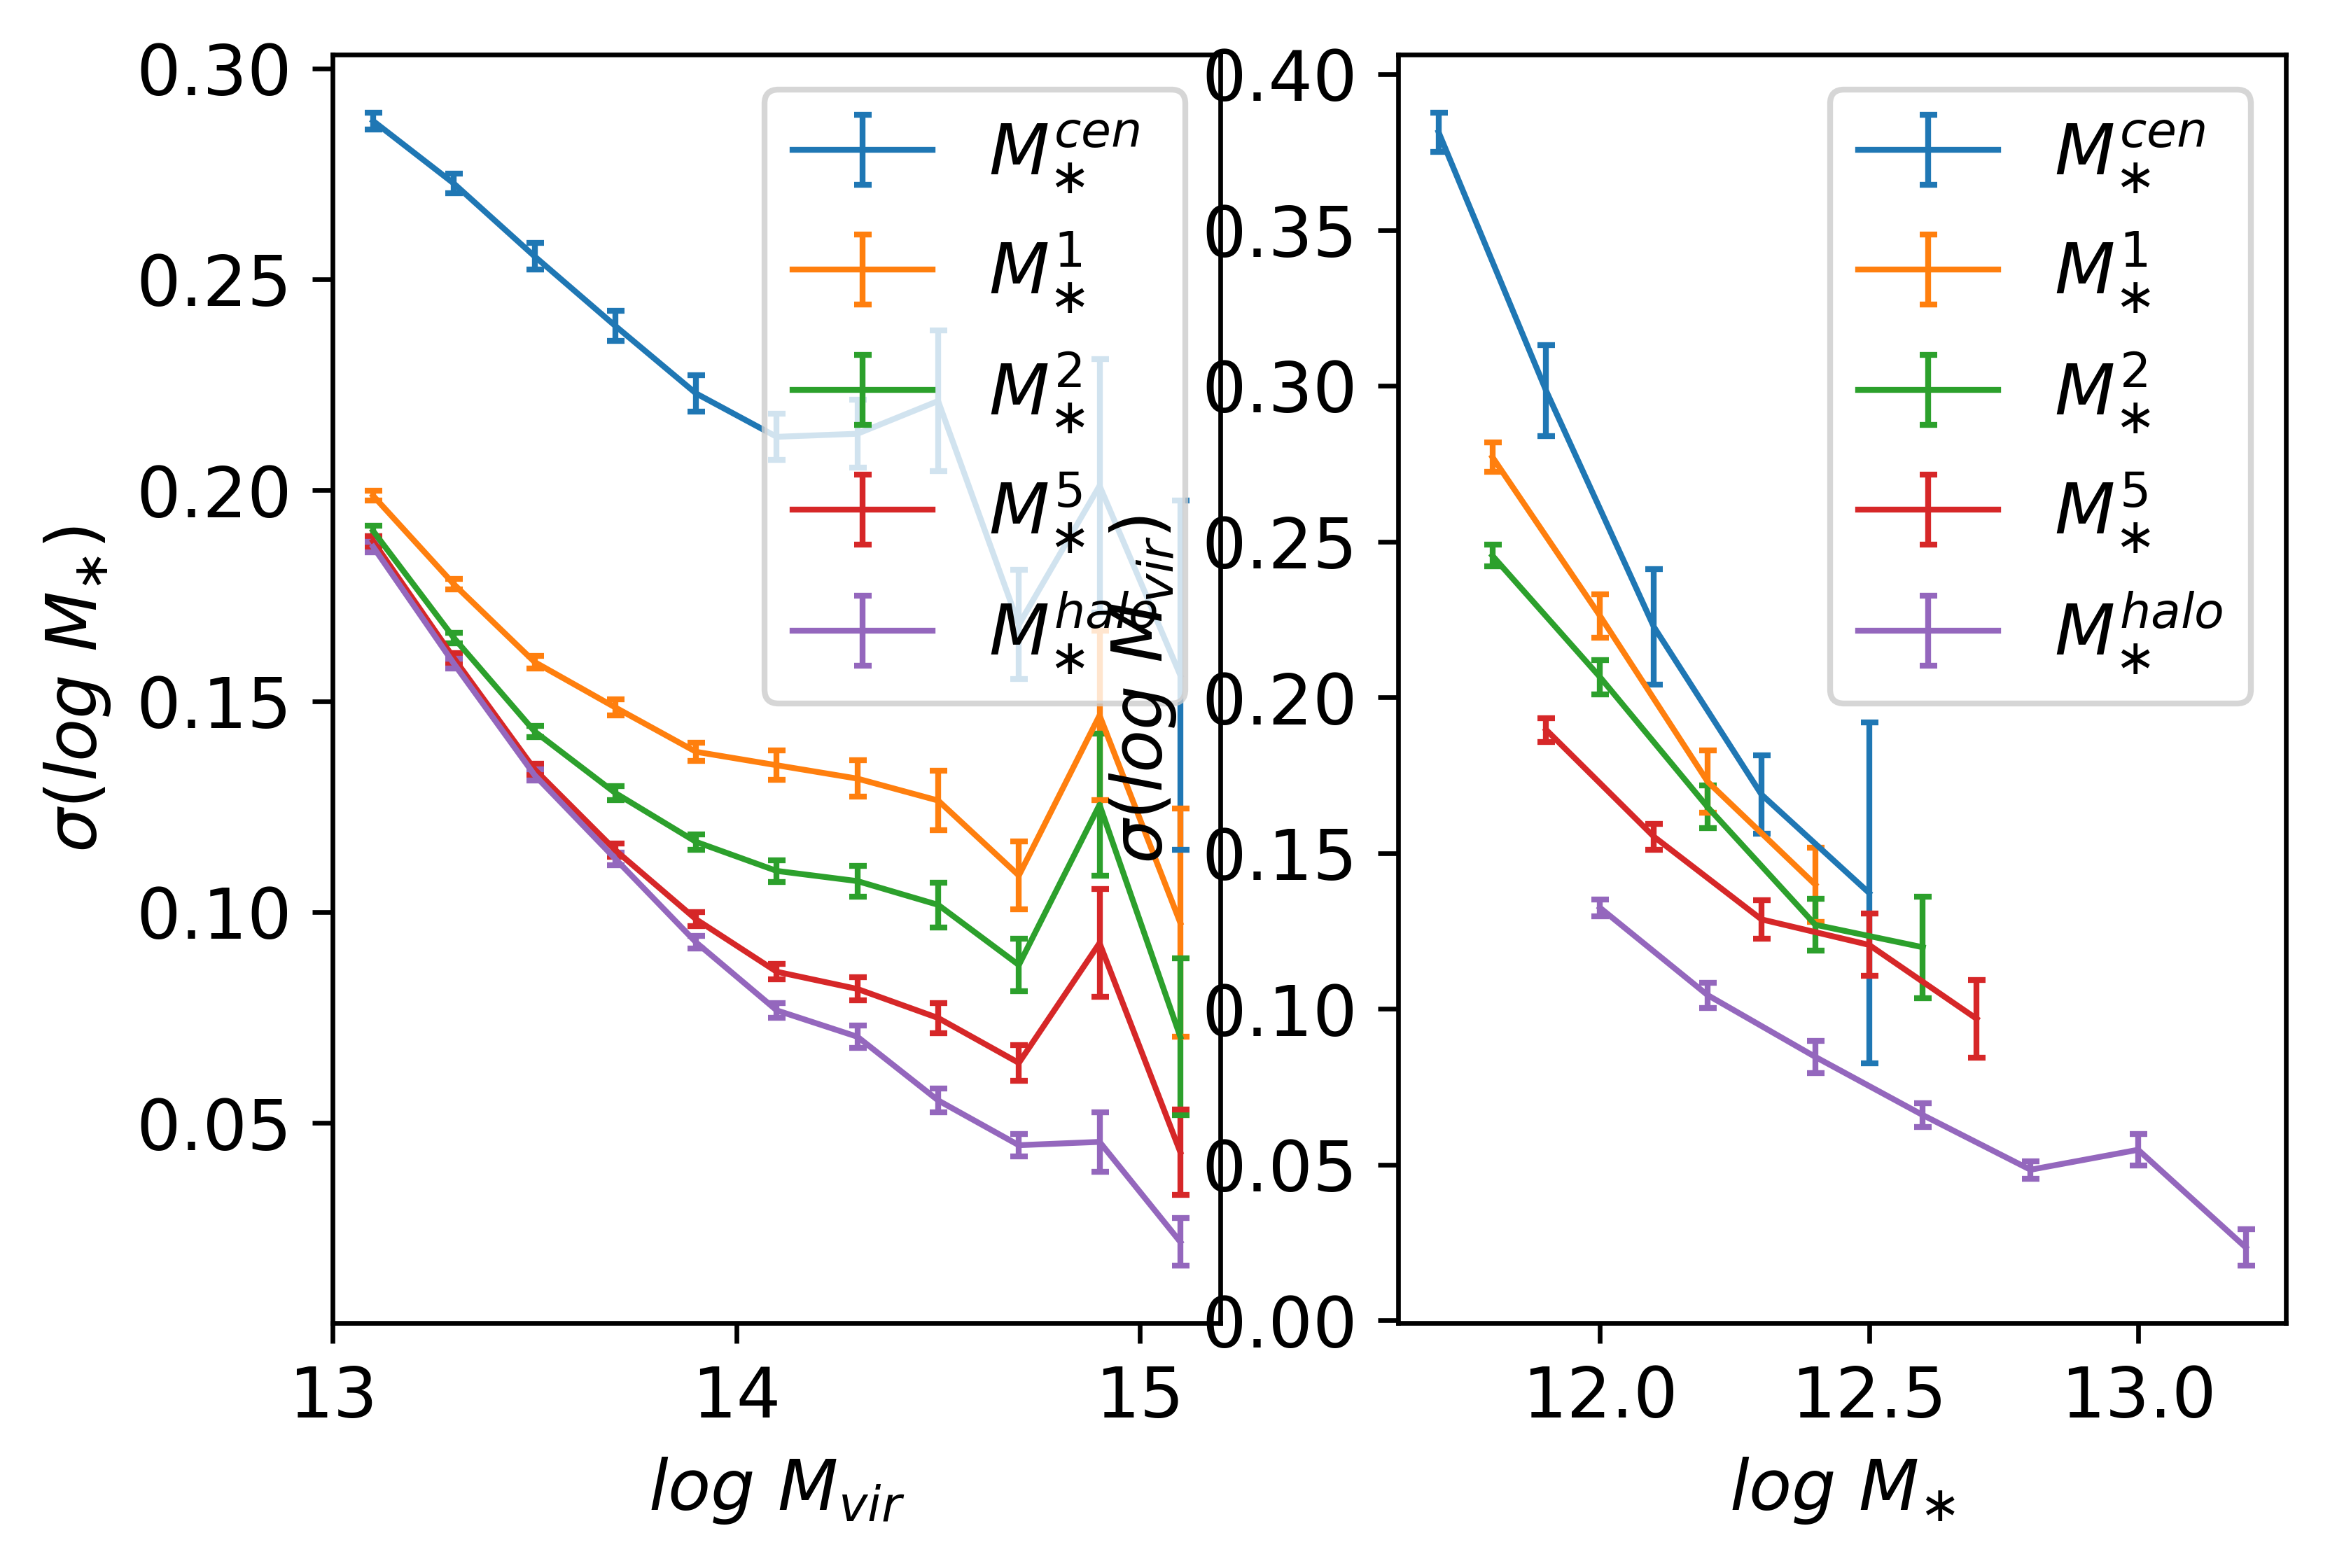

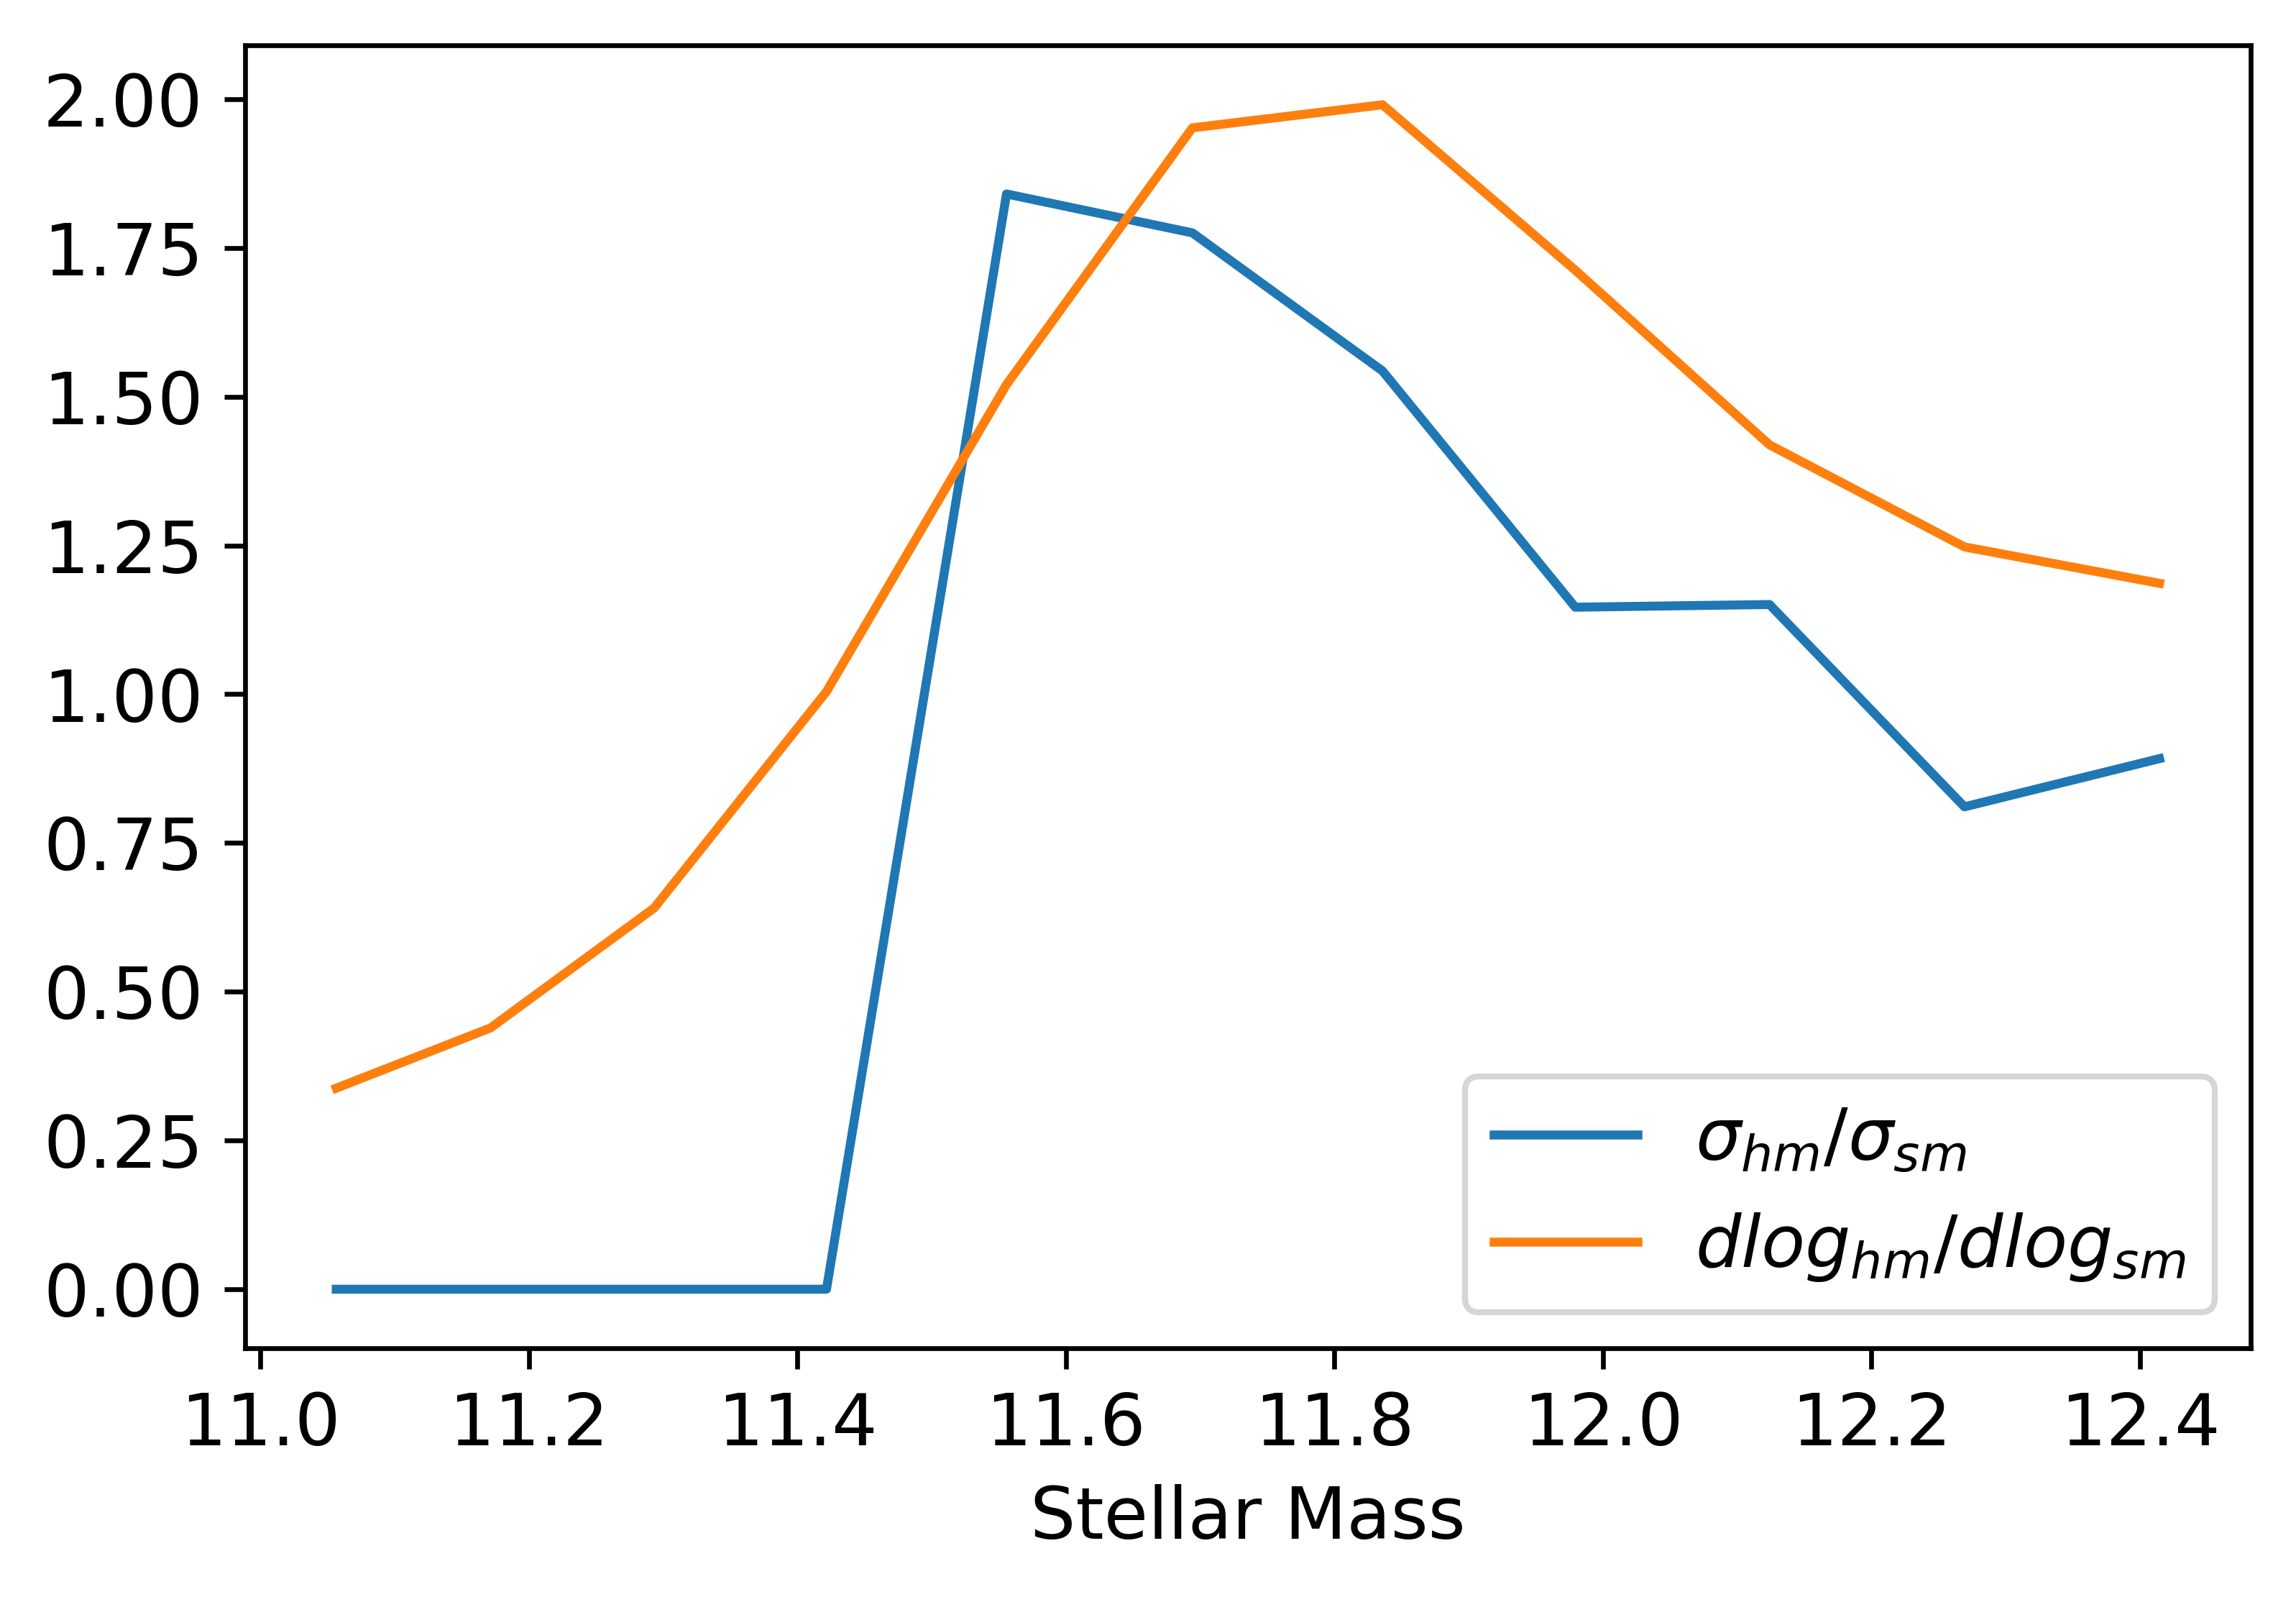

In [11]:
fig, axes = plt.subplots(1, 2)
plots.hm_vs_sm_scatter(data_halo_cut, axes[0])
plots.sm_vs_hm_scatter(data_stellar_cut, axes[1])

x0, y0 = axes[0].lines[0].get_xdata(), axes[0].lines[0].get_ydata()
x1, y1 = axes[1].lines[0].get_xdata(), axes[1].lines[0].get_ydata()

plots.sanity_check_scatter(data_stellar_cut["cen"], data_halo_cut["cen"])

## New heading

# Next